In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
            device = '/gpu:9'
    except RuntimeError as e:
        print(e)

print("device", device)


2024-08-19 19:32:37.899944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 19:32:37.915414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 19:32:37.929220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 19:32:37.933432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 19:32:37.946428: I tensorflow/core/platform/cpu_feature_guar

device /gpu:9


Load the data

In [2]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Load HDF5 data
# h5_filename = '/home/da886/ElectronCountingProject/Small Building Blocks/Data Generated/100K_3electronsOnlyImages_smaller_negative_paddings.h5'
h5_filename = '/home/da886/ElectronCountingProject/Small Building Blocks/Data Generated/500_3electronsOnlyforAnalysis.h5'
with h5py.File(h5_filename, 'r') as f:
    images = np.array(f['images'])
    centers = np.array(f['centers_training'])


### raw image with box locations

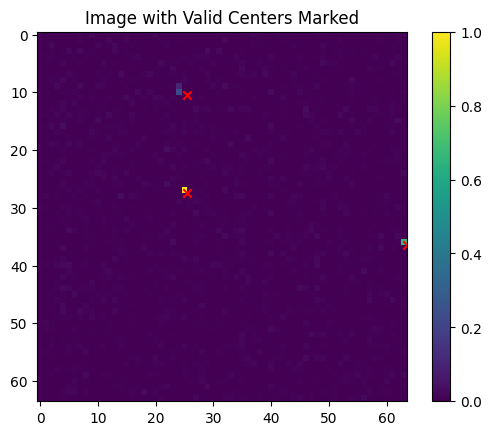

In [4]:
a = np.random.randint(0, len(images))
# a =2
image = images[a]
centerss = centers[a]

# Plot the image with valid centers
plt.imshow(image, )
valid_centers = centerss[centerss[:, 0] == 1]
for center in valid_centers:
    plt.scatter(center[1], center[2], c='red', marker='x')  # Note: center[1] is x and center[2] is y
plt.title('Image with Valid Centers Marked')
plt.colorbar()
plt.show()


Sort the boxes locations in ascending order(top left to bottom right)

In [5]:


# Function to sort centers from top-left to bottom-right
def sort_centers(centers):
    # Sort by y first, then by x
    return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

# Sort the centers for each image
sorted_centers = np.array([sort_centers(image_centers[:, 1:]) for image_centers in centers])


## Normalized Data

In [6]:

# normalized_images = (images+1e-9)/9.26
normalized_images = (images)/np.max(images)
normalized_centers = sorted_centers / [64, 64]
normalized_midpoints =normalized_centers
normalized_midpoints = tf.expand_dims(normalized_midpoints,axis =1)
normalized_midpoints_np = normalized_midpoints.numpy()

2024-08-19 19:33:08.362157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 9, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:cf:00.0, compute capability: 8.0


Range for the inputs

In [6]:
np.max(normalized_images), np.min(normalized_images)

(1.0, 0.0)

Range for the outputs

In [7]:
np.max(normalized_centers), np.min(normalized_centers)

(0.9921875, 0.0234375)

In [7]:
# Perform the random split
train_images, val_images, train_midpoints, val_midpoints = train_test_split(
    normalized_images, normalized_midpoints_np, train_size=0.8, random_state=42
)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

In [11]:
train_images.shape,val_images.shape

((40000, 64, 64), (10000, 64, 64))

In [9]:
batch_size = 600
train_dataset = train_dataset.shuffle(buffer_size=2000,reshuffle_each_iteration= True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)

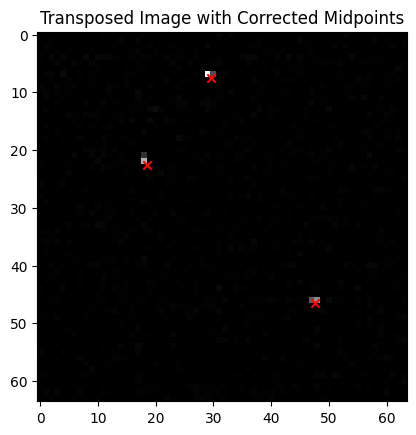

In [13]:

sample_image, sample_midpoints = next(iter(train_dataset))


# Convert TensorFlow tensors to NumPy arrays (if they are tensors)
sample_image = np.array(sample_image[2])
sample_midpoints = np.array(sample_midpoints[2])

# # Transpose the image and correctly swap the midpoints

transposed_image = sample_image.T
transposed_midpoints_corrected = sample_midpoints[:,:, [1, 0]]  # Correctly swap x and y coordinates

# Plot the transposed image with corrected midpoints
plt.imshow(transposed_image, cmap='gray')
plt.scatter(transposed_midpoints_corrected[:,:, 0] * 64, transposed_midpoints_corrected[:,:, 1] * 64, c='red', marker='x')
plt.title('Transposed Image with Corrected Midpoints')
plt.show()


In [11]:
normalized_midpoints 

<tf.Tensor: shape=(50000, 1, 3, 2), dtype=float64, numpy=
array([[[[0.1484375, 0.1171875],
         [0.1171875, 0.2265625],
         [0.3515625, 0.6171875]]],


       [[[0.5078125, 0.0234375],
         [0.2421875, 0.1640625],
         [0.1328125, 0.8828125]]],


       [[[0.4140625, 0.0234375],
         [0.7890625, 0.1484375],
         [0.7890625, 0.1640625]]],


       ...,


       [[[0.7109375, 0.0234375],
         [0.8046875, 0.2890625],
         [0.0234375, 0.8515625]]],


       [[[0.9921875, 0.1015625],
         [0.0390625, 0.6328125],
         [0.1796875, 0.7578125]]],


       [[[0.1953125, 0.2890625],
         [0.3046875, 0.5703125],
         [0.3203125, 0.8515625]]]])>

In [11]:
# from tensorflow.keras import layers


# input_shape = (64, 64,1)
# num_classes = 3
# num_coordinates = 2



# x_input = layers.Input(shape=input_shape)
# #Layer 1
# x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x_input)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.3)(x) 
# x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x) 



# x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x) 


# # x = layers.GlobalAveragePooling2D()(x)
# x = layers.Flatten()(x)




# x_midpoints = layers.Dense(num_classes * num_coordinates,activation='sigmoid', name='x_midpoints')(x)
# x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




# model = tf.keras.models.Model(x_input,x_midpoints_reshape)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 



In [15]:
from tensorflow.keras import layers


input_shape = (64, 64, 1)
num_classes = 5
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)

#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)

#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)


# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input, x_midpoints_reshape)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 



In [26]:
import tensorflow as tf

def custom_mse(y_true, y_pred):
    # Ensuring both tensors are of dtype float64 for higher precision
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    return tf.reduce_mean(tf.square(y_true - y_pred))



def custom_binary_crossentropy(y_true, y_pred):
    # Ensuring both tensors are of dtype float64 for higher precision
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    # Calculate binary crossentropy
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred)



In [19]:
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())
# model.compile(
#     optimizer=optimizer, 
#     loss=
#          custom_mse
    
# )




In [20]:
train_outputs = model.predict(train_images)
val_outputs = model.predict(val_images)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [21]:
loss=tf.keras.losses.MeanSquaredError()
tl =loss(train_outputs,train_midpoints)
vl = loss(val_outputs,val_midpoints)

tl,vl

2024-08-19 19:34:47.896728: W tensorflow/core/framework/op_kernel.cc:1828] INVALID_ARGUMENT: required broadcastable shapes
2024-08-19 19:34:47.896789: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Sub] name: 

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 6)              │         6,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 3, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,328,518 (39.40 MB)

 Trainable params: 10,327,878 (39.40 MB)

 Non-trainable params: 640 (2.50 KB)

In [23]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 200  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/Small Building Blocks/Weights from recommendations/customlossmodel_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)

# Define the ReduceLROnPlateau callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',       # Monitor the validation loss
    factor=0.5,               # Factor by which the learning rate will be reduced
    patience=5,               # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,                # Verbosity mode, 1: output logs
    mode='min',               # Min mode, as we want to reduce the LR when the monitored quantity stops decreasing
    min_lr=3e-12               # Lower bound on the learning rate
)

In [15]:
# history =tf.keras.models.load_model("/home/da886/ElectronCountingProject/weekend steps.keras") 

/home/da886/anaconda3/envs/objectdetection/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
# history = model.fit(train_dataset, epochs=2000, validation_data=val_dataset,callbacks=[checkpoint_callback])
# history = history.fit(train_dataset, epochs=500, validation_data=val_dataset,callbacks=[lr_scheduler])
history = model.fit(train_dataset, epochs=300, validation_data=val_dataset,callbacks=[lr_scheduler])

Epoch 1/300


I0000 00:00:1724091420.580080 1634214 service.cc:146] XLA service 0x7fa36000ae10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724091420.580146 1634214 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-19 18:17:00.654837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-19 18:17:01.035830: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-19 18:17:09.708861: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[600,512,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[600,512,16,16]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_qu

 1/67 ━━━━━━━━━━━━━━━━━━━━ 1:05:23 59s/step - loss: 0.0863

I0000 00:00:1724091478.195782 1634214 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0689

2024-08-19 18:18:13.541021: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[400,512,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[400,512,16,16]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-19 18:18:13.602615: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.061694797s
Trying algorithm eng0{} for conv (f32[400,512,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[400,512,16,16]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_

67/67 ━━━━━━━━━━━━━━━━━━━━ 120s 915ms/step - loss: 0.0683 - val_loss: 0.0971 - learning_rate: 0.0010
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 0.0297 - val_loss: 0.0728 - learning_rate: 0.0010
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 0.0236 - val_loss: 0.0670 - learning_rate: 0.0010
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 0.0177 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 0.0165 - val_loss: 0.0537 - learning_rate: 0.0010
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0158 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0152 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0148 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 9/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - loss: 0.0140 - val_loss: 0.0739 - learning_rate: 0.0010
Epo

dict_keys(['loss', 'val_loss', 'learning_rate'])


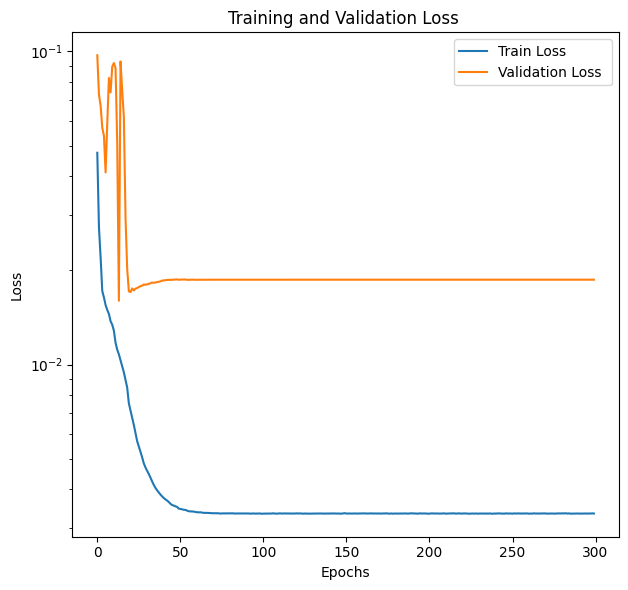

In [25]:


# Print the available keys in the history
print(history.history.keys())

# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If there are specific losses for x_prob and x_midpoints, extract them
train_loss_x_prob = history.history.get('x_prob_reshape_loss', train_loss)
val_loss_x_prob = history.history.get('val_x_prob_reshape_loss', val_loss)
train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)


# Plot the training and validation losses
plt.figure(figsize=(12, 6))

# Plotting x_prob_reshape loss
plt.subplot(1, 2,1)
plt.plot(train_loss_x_prob, label='Train Loss ')
plt.plot(val_loss_x_prob, label='Validation Loss ')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

# # Plotting x_midpoints_reshape loss
# plt.subplot(1, 2, 2)
# plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
# plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss for x_midpoints_reshape')
# plt.legend()

plt.tight_layout()
plt.show()


In [23]:
history =tf.keras.models.load_model("/home/da886/ElectronCountingProject/weekend steps_originalmodel.h5") 

In [24]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))

# train_dataset = train_dataset.batch(200)
# inputs,targets = next(iter(train_dataset))
# output =history.predict(inputs)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
val_dataset = val_dataset.batch(400)
inputs,targets = next(iter(val_dataset))
output =history.predict(inputs)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


In [28]:
h = np.random.randint(0,len(output))
output[h],targets[h]

(array([[[0.05262722, 0.34453282],
         [0.6883221 , 0.6477081 ],
         [0.03604303, 0.9201561 ]]], dtype=float32),
 <tf.Tensor: shape=(1, 3, 2), dtype=float64, numpy=
 array([[[0.0546875, 0.3046875],
         [0.6953125, 0.6171875],
         [0.0546875, 0.9140625]]])>)

In [27]:
import tensorflow as tf

# r = np.random.randint(0,100)
tensor1 = tf.constant(targets, dtype=tf.float64)

tensor2 = tf.constant(output, dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = custom_mse(tensor1, tensor2)
# mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss_fn.numpy())

MSE Loss: 0.005916752795377471


Train dataset

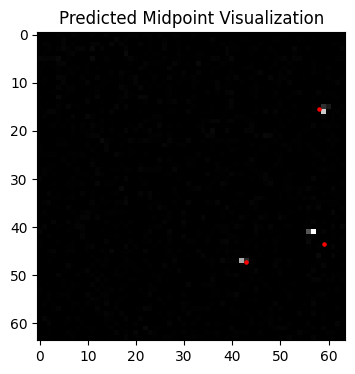

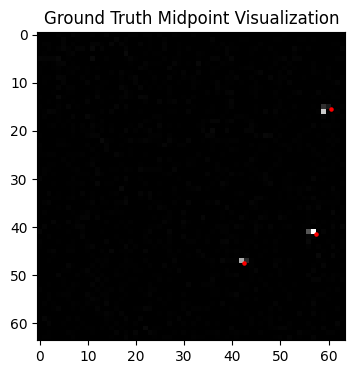

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, midpoints):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

def visualize_midpoints2(image, midpoints):
    """
    Visualizes ground truth midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

# Example usage with random data
t = np.random.randint(0, 200)
# t=5

visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(output[t,0,:,:])*64)
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*64)


Validation dataset

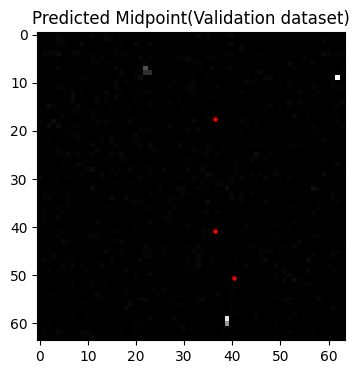

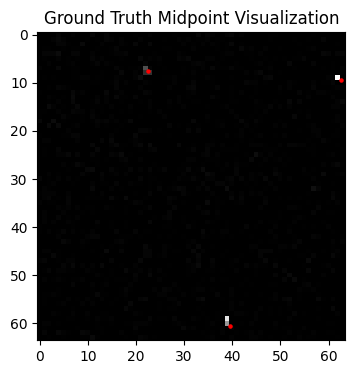

In [30]:
# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
#     """
#     Visualizes midpoints on an image based on a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - threshold: Probability threshold for visualization.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     prob_vector_np = probability_vector
#     midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Predicted Midpoint(Validation dataset)")

#     # Plot midpoints based on probability threshold
#     for i, (p,u) in enumerate(midpoints_np):
#         prob = prob_vector_np[i]
#         if prob > threshold:
#             plt.scatter(p, u, color='red', s=5)
#             # if i == 0:  # Add label only once to avoid repetition in the legend
#             #     plt.legend()
    
    

# t = np.random.randint(0,400)
# # t=12
# visualize_midpoints(tf.convert_to_tensor(inputs[t]), output[0][t].squeeze()*64, tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   
         
            
# def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
#     """
#     Visualizes midpoints on an image based on a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - threshold: Probability threshold for visualization.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     prob_vector_np = probability_vector
#     midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Ground Truth Midpoint Visualization")

#     # Plot midpoints based on probability threshold
#     for i, (x,y) in enumerate(midpoints_np):
#         prob = prob_vector_np[i]
#         if prob > threshold:
#             plt.scatter(x, y, color='red', s=5)
#             # if i == 0:  # Add label only once to avoid repetition in the legend
#             #     plt.legend()

#     plt.show()     
# visualize_midpoints2(tf.convert_to_tensor(inputs[t]), targets['x_probabilities_reshape'][t].numpy().squeeze()*64, tf.convert_to_tensor(targets['x_midpoints_reshape'][t,0,:,:])*[64,64]) ##ground truth
# # visualize_midpoints2(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64])          




In [61]:
# model.save("/home/da886/ElectronCountingProject/weekend steps_5onlyoriginalmodel.keras")